In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
from PIL import Image

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchvision as tv
import torch.nn.functional as F
import cv2
import os

from torch.autograd import Variable

use_cuda = torch.cuda.is_available()
np.load.__defaults__=(None, True, True, 'ASCII')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
class HParams():
    def __init__(self):
        self.image_size = 28
        self.bottleneck_size = 128
        self.enc_hidden_size = 256
        self.dec_hidden_size = 512
        self.Nz = 128
        self.M = 20
        self.dropout = 0.9
        self.batch_size = 100
        self.eta_min = 0.01
        self.R = 0.99995
        self.KL_min = 0.2
        self.wKL = 0.5
        self.lr = 0.001
        self.lr_decay = 0.9999
        self.min_lr = 0.00001
        self.grad_clip = 1.
        self.temperature = 0.4
        self.max_seq_length = 200

hp = HParams()

In [4]:
# We will use this variable in conditional_generation
Nmax = 66

In [5]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [6]:
class ImageEncoder(nn.Module):
    def __init__(self):
        super(ImageEncoder, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(400, 128)  # 6*6 from image dimension
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

    def forward(self, image_paths):
        all_zs = torch.empty(0, 128)
        # Max pooling over a (2, 2) window
        for i, data in enumerate(image_paths):
            img = mpimg.imread(data)
            gray = rgb2gray(img)
            x = torch.from_numpy(gray)
            # change (28,28) to (1,1,28,28)
            x = torch.unsqueeze(x,0)
            x = torch.unsqueeze(x,0)
            #print(f"dimension of x {x.shape}")
            x = F.max_pool2d(F.relu(self.conv1(x.float())), (2, 2))
            # If the size is a square you can only specify a single number
            x = F.max_pool2d(F.relu(self.conv2(x)), 2)
            x = x.view(-1, self.num_flat_features(x))
            
            #print(x.shape) #1 x 400
            x = self.fc1(x)
            #print(all_zs.shape)
            all_zs = torch.cat([all_zs, x], dim=0)
            #all_zs.cat(x)
        return all_zs

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [7]:
class EncoderRNN(nn.Module):
    def __init__(self):
        super(EncoderRNN, self).__init__()
        # bidirectional lstm:
        self.lstm = nn.LSTM(5, hp.enc_hidden_size, \
            dropout=hp.dropout, bidirectional=True)
        # create mu and sigma from lstm's last output:
        self.fc_mu = nn.Linear(2*hp.enc_hidden_size, hp.Nz)
        self.fc_sigma = nn.Linear(2*hp.enc_hidden_size, hp.Nz)
        # active dropout:
        self.train()

    def forward(self, inputs, batch_size, hidden_cell=None):
        if hidden_cell is None:
            # then must init with zeros
            if use_cuda:
                hidden = torch.zeros(2, batch_size, hp.enc_hidden_size).cuda()
                cell = torch.zeros(2, batch_size, hp.enc_hidden_size).cuda()
            else:
                hidden = torch.zeros(2, batch_size, hp.enc_hidden_size)
                cell = torch.zeros(2, batch_size, hp.enc_hidden_size)
            hidden_cell = (hidden, cell)
        _, (hidden,cell) = self.lstm(inputs.float(), hidden_cell)
        # hidden is (2, batch_size, hidden_size), we want (batch_size, 2*hidden_size):
        hidden_forward, hidden_backward = torch.split(hidden,1,0)
        hidden_cat = torch.cat([hidden_forward.squeeze(0), hidden_backward.squeeze(0)],1)
        # mu and sigma:
        mu = self.fc_mu(hidden_cat)
        sigma_hat = self.fc_sigma(hidden_cat)
        sigma = torch.exp(sigma_hat/2.)
        # N ~ N(0,1)
        z_size = mu.size()
                                   
        if use_cuda:
            N = torch.normal(torch.zeros(z_size),torch.ones(z_size)).cuda()
        else:
            N = torch.normal(torch.zeros(z_size),torch.ones(z_size))
        z = mu + sigma*N
        # mu and sigma_hat are needed for LKL loss
        return z, mu, sigma_hat #[100,128]

In [8]:
class DecoderRNN(nn.Module):
    def __init__(self):
        super(DecoderRNN, self).__init__()
        # to init hidden and cell from z:
        self.fc_hc = nn.Linear(hp.Nz, 2*hp.dec_hidden_size)
        # unidirectional lstm:
        self.lstm = nn.LSTM(hp.Nz+5, hp.dec_hidden_size, dropout=hp.dropout)
        # create proba distribution parameters from hiddens:
        self.fc_params = nn.Linear(hp.dec_hidden_size,6*hp.M+3)

    def forward(self, inputs, z, hidden_cell=None):
        if hidden_cell is None:
            # then we must init from z
            hidden,cell = torch.split(F.tanh(self.fc_hc(z)),hp.dec_hidden_size,1)
            hidden_cell = (hidden.unsqueeze(0).contiguous(), cell.unsqueeze(0).contiguous())
        outputs,(hidden,cell) = self.lstm(inputs, hidden_cell)
        # in training we feed the lstm with the whole input in one shot
        # and use all outputs contained in 'outputs', while in generate
        # mode we just feed with the last generated sample:
        if self.training:
            y = self.fc_params(outputs.view(-1, hp.dec_hidden_size))
        else:
            y = self.fc_params(hidden.view(-1, hp.dec_hidden_size))
        # separate pen and mixture params:
        params = torch.split(y,6,1)
        params_mixture = torch.stack(params[:-1]) # trajectory
        params_pen = params[-1] # pen up/down
        # identify mixture params:
        pi,mu_x,mu_y,sigma_x,sigma_y,rho_xy = torch.split(params_mixture,1,2)
        # preprocess params::
        if self.training:
            len_out = Nmax+1
        else:
            len_out = 1
                                   
        pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
        sigma_x = torch.exp(sigma_x.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
        sigma_y = torch.exp(sigma_y.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
        rho_xy = torch.tanh(rho_xy.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
        mu_x = mu_x.transpose(0,1).squeeze().contiguous().view(len_out,-1,hp.M)
        mu_y = mu_y.transpose(0,1).squeeze().contiguous().view(len_out,-1,hp.M)
        q = F.softmax(params_pen).view(len_out,-1,3)
        return pi,mu_x,mu_y,sigma_x,sigma_y,rho_xy,q,hidden,cell

In [9]:
def lr_decay(optimizer):
    """Decay learning rate by a factor of lr_decay"""
    for param_group in optimizer.param_groups:
        if param_group['lr']>hp.min_lr:
            param_group['lr'] *= hp.lr_decay
    return optimizer

In [10]:
# resize real images
def preprocess_image(dir_in, dir_out):
    for img in os.listdir(dir_in):         
        img_name = os.path.splitext(img)[0]    # remove extension
        image = Image.open(os.path.join(dir_in, img))
        new_image = image.resize((28, 28))
        new_image.save(f"{dir_out}/{img_name}.png")
        
# resize sketch images
def preprocess_sketch(dir_in, dir_out):
    for sketch in os.listdir(dir_in):         
        sketch_name = os.path.splitext(sketch)[0]    # remove extension
        s_image = Image.open(os.path.join(dir_in, sketch))
        new_image = s_image.resize((28, 28))
        new_image.save(f"{dir_out}/{sketch_name}.png")

In [23]:
def sample_bivariate_normal(temp, mu_x,mu_y,sigma_x,sigma_y,rho_xy, greedy=False):
    # inputs must be floats
    if greedy:
         return mu_x,mu_y
    mean = [mu_x, mu_y]
    sigma_x *= np.sqrt(temp)
    sigma_y *= np.sqrt(temp)
    cov = [[sigma_x * sigma_x, rho_xy * sigma_x * sigma_y],\
        [rho_xy * sigma_x * sigma_y, sigma_y * sigma_y]]
    x = np.random.multivariate_normal(mean, cov, 1)
    return x[0][0], x[0][1]    
        
def make_image(sequence):
    """plot drawing with separated strokes"""
    strokes = np.split(sequence, np.where(sequence[:,2]>0)[0]+1)
    fig = plt.figure()
    ax1 = fig.add_subplot(1,1,1)
    for s in strokes:
        plt.plot(s[:,0],-s[:,1])
    #print("Outputting sketch")
    #name = str(epoch)+name+'.jpg'
    #plt.savefig(F"./outputs_complete/{name}")
    plt.show()

In [22]:
class NewModel():
    def __init__(self):
        self.s2s_encoder = ImageEncoder().to(device)
        self.p2s_encoder = ImageEncoder().to(device)
        self.decoder = DecoderRNN().to(device)
        self.p2s_encoder_optimizer = optim.Adam(self.p2s_encoder.parameters(), hp.lr)
        self.eta_step = hp.eta_min
        self.img_dir = '../Datasets/sketchy_chair/chair_p_train_resized'
        self.sketch_dir = '../Datasets/sketchy_chair/chair_s_train_resized'
        self.img_paths = []
        self.sketch_paths = []
            
    # For each img, there are multiple sketches. 
    # e.g. n02121620.png -> n02121620-i.png (i = 1,2,3,...)
    
    # Add paired paths to img_paths and sketch_paths arrays.  
    def process_data(self):
        for img in os.listdir(self.img_dir):         
            img_name = os.path.splitext(img)[0]    # remove extension
            i = 1
            while(os.path.exists(f"{self.sketch_dir}/{img_name}-{i}.png")):
                self.img_paths.append(os.path.join(self.img_dir, img))
                sketch = f"{img_name}-{i}.png"
                self.sketch_paths.append(os.path.join(self.sketch_dir, sketch))
                i += 1                                
    
    # load pre-trained models for training p2s_encoder
    def load_for_training(self, s2s_encoder, decoder):
        s2s_encoder = torch.load(s2s_encoder)
        decoder = torch.load(decoder)
        self.s2s_encoder.load_state_dict(s2s_encoder)
        self.decoder.load_state_dict(decoder)
        
    # load the final encoder and decoder for testing the p2s model
    def load(self, encoder, decoder):
        p2s_encoder = torch.load(encoder)
        decoder = torch.load(decoder)
        self.p2s_encoder.load_state_dict(p2s_encoder)
        self.decoder.load_state_dict(decoder)        
            
    def train(self, epoch):
        self.p2s_encoder.train()
        self.decoder.train()
        z_target = self.s2s_encoder(self.sketch_paths)
        z_pred = self.p2s_encoder(self.img_paths)
        
        self.p2s_encoder_optimizer.zero_grad()
        self.eta_step = 1-(1-hp.eta_min)*hp.R
        
        loss = self.encoder_loss(z_pred, z_target)
        loss.backward()
        
        nn.utils.clip_grad_norm(self.p2s_encoder.parameters(), hp.grad_clip)
        
        self.p2s_encoder_optimizer.step()
        
        if epoch%1==0:
            print(f"The number of epochs is: {epoch} and loss is {loss}")
            self.p2s_encoder_optimizer = lr_decay(self.p2s_encoder_optimizer)
        if epoch%100==0:
            self.save(epoch)
        
    def encoder_loss(self, pred_z, target_z):
        criterion = nn.MSELoss()
        return criterion(pred_z, target_z)
    
    def save(self, epoch):
        random_number = np.random.rand()
        enc_model_name = 'img_encoder_%3f_%d.pt' % (random_number, epoch)
        enc_path = F"../p2s_models/chair/{enc_model_name}"
        torch.save(self.p2s_encoder.state_dict(), enc_path)
        
    def conditional_generation(self, z, temp):
        #batch,lengths = make_batch(1)
        # should remove dropouts:
        self.p2s_encoder.train(False)
        self.decoder.train(False)
        # encode:
        #z, _, _ = self.encoder(batch, 1)
        if use_cuda:
            sos = Variable(torch.Tensor([0,0,1,0,0]).view(1,1,-1).cuda())
        else:
            sos = Variable(torch.Tensor([0,0,1,0,0]).view(1,1,-1))
        s = sos
        seq_x = []
        seq_y = []
        seq_z = []
        hidden_cell = None
        for i in range(Nmax):
            input = torch.cat([s,z.unsqueeze(0)],2)
            # decode:
            self.pi, self.mu_x, self.mu_y, self.sigma_x, self.sigma_y, \
                self.rho_xy, self.q, hidden, cell = \
                    self.decoder(input, z, hidden_cell)
            hidden_cell = (hidden, cell)
            # sample from parameters:
            s, dx, dy, pen_down, eos = self.sample_next_state(temp)
            #------
            seq_x.append(dx)
            seq_y.append(dy)
            seq_z.append(pen_down)
            if eos:
                print(i)
                break
        # visualize result:
        x_sample = np.cumsum(seq_x, 0)
        y_sample = np.cumsum(seq_y, 0)
        z_sample = np.array(seq_z)
        sequence = np.stack([x_sample,y_sample,z_sample]).T
        make_image(sequence)      
        
    def sample_next_state(self, temp):
        def adjust_temp(pi_pdf):
            pi_pdf = np.log(pi_pdf)/temp
            pi_pdf -= pi_pdf.max()
            pi_pdf = np.exp(pi_pdf)
            pi_pdf /= pi_pdf.sum()
            return pi_pdf

        # get mixture indice:
        pi = self.pi.data[0,0,:].cpu().numpy()
        pi = adjust_temp(pi)
        pi_idx = np.random.choice(hp.M, p=pi)
        # get pen state:
        q = self.q.data[0,0,:].cpu().numpy()
        q = adjust_temp(q)
        q_idx = np.random.choice(3, p=q)
        # get mixture params:
        mu_x = self.mu_x.data[0,0,pi_idx]
        mu_y = self.mu_y.data[0,0,pi_idx]
        sigma_x = self.sigma_x.data[0,0,pi_idx]
        sigma_y = self.sigma_y.data[0,0,pi_idx]
        rho_xy = self.rho_xy.data[0,0,pi_idx]
        x,y = sample_bivariate_normal(temp, mu_x,mu_y,sigma_x,sigma_y,rho_xy,greedy=False)
        next_state = torch.zeros(5)
        next_state[0] = x
        next_state[1] = y
        next_state[q_idx+2] = 1
        if use_cuda:
            return Variable(next_state.cuda()).view(1,1,-1),x,y,q_idx==1,q_idx==2
        else:
            return Variable(next_state).view(1,1,-1),x,y,q_idx==1,q_idx==2

In [13]:
# process and train data
# preprocess_image('../Datasets/sketchy_chair/chair_p_train', '../Datasets/sketchy_chair/chair_p_train_resized')
# preprocess_sketch('../Datasets/sketchy_chair/chair_s_train', '../Datasets/sketchy_chair/chair_s_train_resized')
# preprocess_image('../Datasets/sketchy_chair/chair_p_test', '../Datasets/sketchy_chair/chair_p_test_resized')
# preprocess_sketch('../Datasets/sketchy_chair/chair_s_test', '../Datasets/sketchy_chair/chair_s_test_resized')

# model = NewModel()
# model.load_for_training('../Models_Complete_Chairs/sketchRNN_encoder_0.874900_18000.pt', '../Models_Complete_Chairs/sketchRNN_decoder_0.874900_18000.pt')
# model.process_data()
# for epoch in range(30001):
#     model.train(epoch)

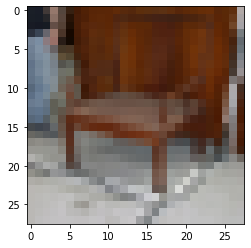

9


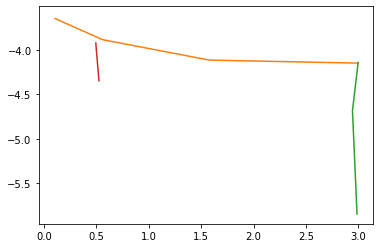

In [30]:
# test the model
model = NewModel()
model.load('../p2s_models/chair/img_encoder_0.545542_30000.pt', '../Models_Complete_Chairs/sketchRNN_decoder_0.874900_18000.pt')
# img_test = '../Datasets/sketchy_cat/cat_p_test_resized/n02121620_26845.png'
img_test = '../Datasets/sketchy_chair/chair_p_test_resized/n02738535_2586.png'
img = mpimg.imread(img_test)
imgplot = plt.imshow(img)
plt.show()
z = model.p2s_encoder([img_test])
model.conditional_generation(z, 0.1)

# Compare with the paired sketch image input, if it's bad its the sketchrnn on that specific image
# Generalisation

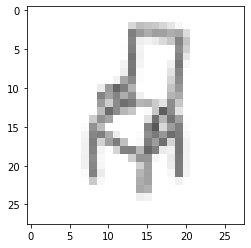

8


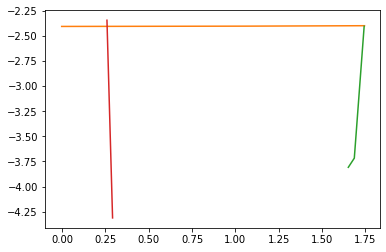

In [31]:
# test the model
model = NewModel()
model.load('../p2s_models/chair/img_encoder_0.545542_30000.pt', '../Models_Complete_Chairs/sketchRNN_decoder_0.874900_18000.pt')
# img_test = '../Datasets/sketchy_cat/cat_p_test_resized/n02121620_26845.png'
img_test = '../Datasets/sketchy_chair/chair_s_test_resized/n02738535_2586-3.png'
img = mpimg.imread(img_test)
imgplot = plt.imshow(img)
plt.show()
z = model.p2s_encoder([img_test])
model.conditional_generation(z, 0.1)

# Compare with the paired sketch image input, if it's bad its the sketchrnn on that specific image
# Generalisation